# Autoencoder


## Setup

In [1]:
import torch
import torch.nn as nn
from torch.nn import init
from torch.autograd import Variable
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision.datasets as datasets

import numpy as np

import matplotlib
# Force matplotlib to not use any Xwindows backend.
# matplotlib.use('Agg')

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from torchvision.utils import save_image
import os


def to_img(x):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    x = x.view(x.size(0), 1, 28, 28)
    return x


# Set parameters 
num_epochs = 2000
batch_size = 50

learning_rate = 0.001
crop_img_width = 64
channel_size = 3

## Dataset


In [11]:
img_transform = transforms.Compose([
    transforms.RandomCrop(crop_img_width),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# data
dataset = datasets.ImageFolder(root='../dataset_center_pixel', transform=img_transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


## Show images

In [3]:
# get a batch of images
inputs = dataloader.__iter__().next()
# inputs = next(iter(dataloader))


===== in function =====
type(images) <class 'numpy.ndarray'>
image.shape before (50, 12288)
image.shape after (50, 12288)


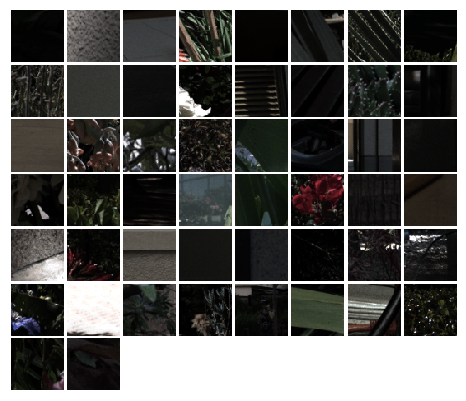

In [56]:

def show_images(images):
    # images = images * 255.0
    print('===== in function =====')
    print('type(images)', type(images))
    img_max = np.max(images)
    img_min = np.min(images)
    images = 255.0 * (images - img_min) / (img_max - img_min)
    
    print('image.shape before', images.shape)
    # print(images.shape)
    images = np.reshape(images, [images.shape[0], -1])  # images reshape to (batch_size, D)
    print('image.shape after', images.shape)
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    sqrtimg = int(np.ceil(np.sqrt(images.shape[1] / 3)))

    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        img = img.reshape([3,sqrtimg,sqrtimg])
        img = np.swapaxes(np.swapaxes(img,1,2),0,2)
        plt.imshow(img.astype('uint8'))
    plt.show()
    # plt.pause(0.001)
    return 

def show_images_large(images):
    # images = images * 255.0
    img_max = np.max(images)
    img_min = np.min(images)
    images = 255.0 * (images - img_min) / (img_max - img_min)
    
    # print(images.shape)
    images = np.reshape(images, [images.shape[0], -1])  # images reshape to (batch_size, D)
    print(images.shape)
    sqrtn = int(np.ceil(images.shape[0]))
    sqrtimg = int(np.ceil(images.shape[1] / 3))

    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        img = img.reshape([1,sqrtimg,sqrtimg])
        img = np.swapaxes(np.swapaxes(img,1,2),0,2)
        plt.imshow(img.astype('uint8'))
    plt.show()
    # plt.pause(0.001)
    return 

# assume input (channel, y, x)
def show_np_img(img):
    img = 255.0*(img-np.min(img)) / (np.max(img)-np.min(img))
    img = np.swapaxes(np.swapaxes(img,1,2),0,2)

    plt.imshow(img.astype('uint8'))
    plt.show()


to_show = inputs[0].view(batch_size, crop_img_width*crop_img_width*channel_size).numpy().squeeze()
show_images(to_show)


## CPU / GPU

In [5]:
dtype = torch.FloatTensor
# dtype = torch.cuda.FloatTensor ## UNCOMMENT THIS LINE IF YOU'RE ON A GPU!

## Autoencoder

In [59]:
# Encoder 
# torch.nn.Conv2d(in_channels, out_channels, kernel_size,
#                 stride=1, padding=0, dilation=1,
#                 groups=1, bias=True)
# batch x 1 x 28 x 28 -> batch x 512

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder,self).__init__()
        self.encoder = nn.Sequential(
                        nn.Conv2d(channel_size, 12, 3, stride=1, padding=0),   # batch x 12 x 62 x 62
                        nn.ReLU(),
                        nn.Conv2d(12, 12, 3, stride=1, padding=0),   # batch x 16 x 60 x 60
                        nn.ReLU(),
                        nn.MaxPool2d(2, 2),  # batch x 12 x 30 x 30
                        nn.Conv2d(12, 24, 3, stride=1, padding=0),  # batch x 24 x 28 x 28
                        nn.ReLU(),
                        nn.MaxPool2d(2, 2),  # batch x 24 x 14 x 14
        )
        self.decoder = nn.Sequential(
                        nn.ConvTranspose2d(24, 12, 3, stride=2),  # batch x 12 x 29 x 29
                        nn.ReLU(),
                        nn.BatchNorm2d(12),
                        nn.ConvTranspose2d(12, 12, 3, 1, padding=0),  # batch x 64 x 31 x 31
                        nn.ReLU(),
                        nn.BatchNorm2d(12),
                        nn.ConvTranspose2d(12, channel_size, 4, stride=2, padding=0),  # batch x 64 x 7 x 7
        )
        
                
    def forward(self,x):
        out = self.encoder(x)
        out = self.decoder(out)
        # out = out.view(batch_size, -1)
        return out

In [60]:
# Check output of autoencoder

autoencoder = Autoencoder().type(dtype)

for image, _ in dataloader: # if this is in dataset, we'd lose the batch dimension 
    image = Variable(image).type(dtype)
    
    output = autoencoder(image)
    print(output.size())
    break

torch.Size([50, 3, 64, 64])


## Noise

In [89]:
def sample_noise(batch_size, dim):
    """
    Generate a PyTorch Tensor of uniform random noise.

    Input:
    - batch_size: Integer giving the batch size of noise to generate.
    - dim: Integer giving the dimension of noise to generate.
    
    Output:
    - A PyTorch Tensor of shape (batch_size, dim) containing uniform
      random noise in the range (-1, 1).
    """
    noise = torch.randn(batch_size, dim) * 2 - 1
    return noise
    
# test_sample_noise()
class DynamicGNoise(nn.Module):
    def __init__(self, shape, std=0.05):
        super().__init__()
        self.noise = Variable(torch.zeros(shape,shape).type(dtype))
        self.std   = std
        
    def forward(self, x):
        if not self.training: return x
        self.noise.data.normal_(0, std=self.std)
        
        print(x.size(), self.noise.size())
        return x + self.noise.expand(x.size())

def noisy_tensor(input_tensor, noise_factor):
    noise = torch.randn(input_tensor.size()) / noise_factor
    image_n = torch.add(input_tensor, noise)
    image_n = torch.clamp(image_n, -1, 1)
    return image_n

## Loss func and optimizer

In [9]:
# loss func and optimizer
# we compute reconstruction after decoder so use Mean Squared Error
# In order to use multi parameters with one optimizer,
# concat parameters after changing into list

parameters = autoencoder.parameters()
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(parameters, lr=learning_rate)

## Running 


--------model restored--------

Starting run 

epoch [1/2000], loss:0.0045
===== in function =====
type(images) <class 'numpy.ndarray'>
image.shape before (16, 3, 64, 64)
image.shape after (16, 12288)


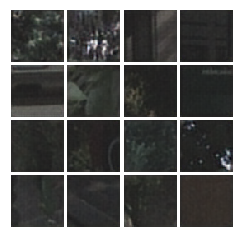

/Users/Max/Documents/lightfield_research/assignment3/.env/lib/python3.5/site-packages/torch/serialization.py:147: UserWarning: Couldn't retrieve source code for container of type Autoencoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


model saved as:  ./saved_models/deno_autoencoder3_epoch_140.pkl
epoch [2/2000], loss:0.0049
epoch [3/2000], loss:0.0050
epoch [4/2000], loss:0.0044
epoch [5/2000], loss:0.0040
epoch [6/2000], loss:0.0035
epoch [7/2000], loss:0.0054
epoch [8/2000], loss:0.0034
epoch [9/2000], loss:0.0044
epoch [10/2000], loss:0.0035
epoch [11/2000], loss:0.0052
===== in function =====
type(images) <class 'numpy.ndarray'>
image.shape before (16, 3, 64, 64)
image.shape after (16, 12288)


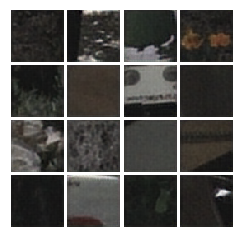

model saved as:  ./saved_models/deno_autoencoder3_epoch_150.pkl
epoch [12/2000], loss:0.0041
epoch [13/2000], loss:0.0058
epoch [14/2000], loss:0.0036
epoch [15/2000], loss:0.0048
epoch [16/2000], loss:0.0055
epoch [17/2000], loss:0.0050
epoch [18/2000], loss:0.0044
epoch [19/2000], loss:0.0047
epoch [20/2000], loss:0.0037
epoch [21/2000], loss:0.0044
===== in function =====
type(images) <class 'numpy.ndarray'>
image.shape before (16, 3, 64, 64)
image.shape after (16, 12288)


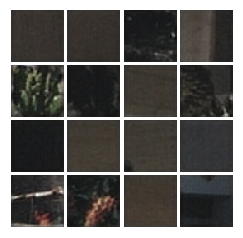

model saved as:  ./saved_models/deno_autoencoder3_epoch_160.pkl
epoch [22/2000], loss:0.0063
epoch [23/2000], loss:0.0058
epoch [24/2000], loss:0.0052
epoch [25/2000], loss:0.0047
epoch [26/2000], loss:0.0035
epoch [27/2000], loss:0.0036
epoch [28/2000], loss:0.0063
epoch [29/2000], loss:0.0044
epoch [30/2000], loss:0.0047
epoch [31/2000], loss:0.0041
===== in function =====
type(images) <class 'numpy.ndarray'>
image.shape before (16, 3, 64, 64)
image.shape after (16, 12288)


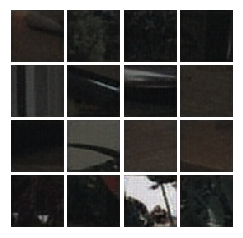

model saved as:  ./saved_models/deno_autoencoder3_epoch_170.pkl
epoch [32/2000], loss:0.0035
epoch [33/2000], loss:0.0046
epoch [34/2000], loss:0.0029
epoch [35/2000], loss:0.0041
epoch [36/2000], loss:0.0035
epoch [37/2000], loss:0.0040
epoch [38/2000], loss:0.0037
epoch [39/2000], loss:0.0033
epoch [40/2000], loss:0.0051
epoch [41/2000], loss:0.0084
===== in function =====
type(images) <class 'numpy.ndarray'>
image.shape before (16, 3, 64, 64)
image.shape after (16, 12288)


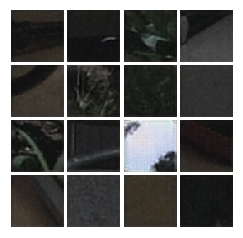

model saved as:  ./saved_models/deno_autoencoder3_epoch_180.pkl
epoch [42/2000], loss:0.0037
epoch [43/2000], loss:0.0051
epoch [44/2000], loss:0.0038
epoch [45/2000], loss:0.0050
epoch [46/2000], loss:0.0041
epoch [47/2000], loss:0.0055
epoch [48/2000], loss:0.0053
epoch [49/2000], loss:0.0035
epoch [50/2000], loss:0.0049
epoch [51/2000], loss:0.0052
===== in function =====
type(images) <class 'numpy.ndarray'>
image.shape before (16, 3, 64, 64)
image.shape after (16, 12288)


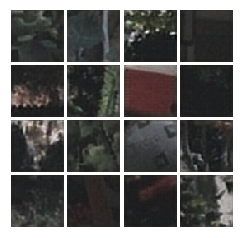

model saved as:  ./saved_models/deno_autoencoder3_epoch_190.pkl
epoch [52/2000], loss:0.0052
epoch [53/2000], loss:0.0044
epoch [54/2000], loss:0.0035
epoch [55/2000], loss:0.0043
epoch [56/2000], loss:0.0041
epoch [57/2000], loss:0.0053
epoch [58/2000], loss:0.0037
epoch [59/2000], loss:0.0040
epoch [60/2000], loss:0.0039
epoch [61/2000], loss:0.0056
===== in function =====
type(images) <class 'numpy.ndarray'>
image.shape before (16, 3, 64, 64)
image.shape after (16, 12288)


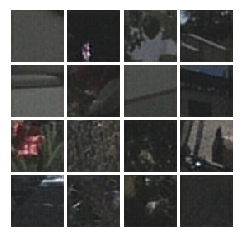

model saved as:  ./saved_models/deno_autoencoder3_epoch_200.pkl
epoch [62/2000], loss:0.0042
epoch [63/2000], loss:0.0045
epoch [64/2000], loss:0.0039
epoch [65/2000], loss:0.0043
epoch [66/2000], loss:0.0043
epoch [67/2000], loss:0.0038
epoch [68/2000], loss:0.0033
epoch [69/2000], loss:0.0074
epoch [70/2000], loss:0.0052
epoch [71/2000], loss:0.0044
===== in function =====
type(images) <class 'numpy.ndarray'>
image.shape before (16, 3, 64, 64)
image.shape after (16, 12288)


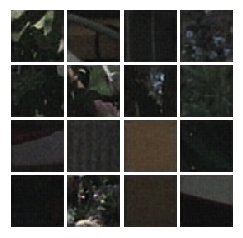

model saved as:  ./saved_models/deno_autoencoder3_epoch_210.pkl
epoch [72/2000], loss:0.0047
epoch [73/2000], loss:0.0038
epoch [74/2000], loss:0.0055
epoch [75/2000], loss:0.0073
epoch [76/2000], loss:0.0045
epoch [77/2000], loss:0.0075
epoch [78/2000], loss:0.0033
epoch [79/2000], loss:0.0038
epoch [80/2000], loss:0.0050
epoch [81/2000], loss:0.0068
===== in function =====
type(images) <class 'numpy.ndarray'>
image.shape before (16, 3, 64, 64)
image.shape after (16, 12288)


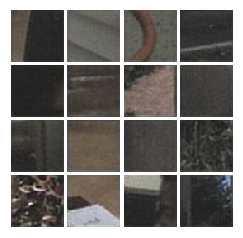

model saved as:  ./saved_models/deno_autoencoder3_epoch_220.pkl
epoch [82/2000], loss:0.0037
epoch [83/2000], loss:0.0051
epoch [84/2000], loss:0.0045
epoch [85/2000], loss:0.0043
epoch [86/2000], loss:0.0046
epoch [87/2000], loss:0.0044
epoch [88/2000], loss:0.0038
epoch [89/2000], loss:0.0052
epoch [90/2000], loss:0.0060
epoch [91/2000], loss:0.0052
===== in function =====
type(images) <class 'numpy.ndarray'>
image.shape before (16, 3, 64, 64)
image.shape after (16, 12288)


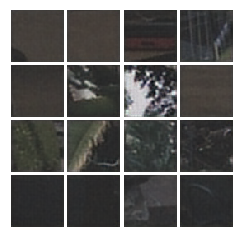

model saved as:  ./saved_models/deno_autoencoder3_epoch_230.pkl
epoch [92/2000], loss:0.0042
epoch [93/2000], loss:0.0064
epoch [94/2000], loss:0.0035
epoch [95/2000], loss:0.0047
epoch [96/2000], loss:0.0064
epoch [97/2000], loss:0.0038
epoch [98/2000], loss:0.0043
epoch [99/2000], loss:0.0032
epoch [100/2000], loss:0.0043
epoch [101/2000], loss:0.0054
===== in function =====
type(images) <class 'numpy.ndarray'>
image.shape before (16, 3, 64, 64)
image.shape after (16, 12288)


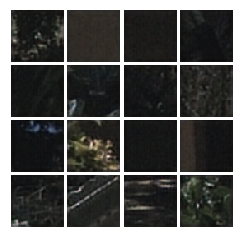

model saved as:  ./saved_models/deno_autoencoder3_epoch_240.pkl
epoch [102/2000], loss:0.0038
epoch [103/2000], loss:0.0059
epoch [104/2000], loss:0.0040
epoch [105/2000], loss:0.0058
epoch [106/2000], loss:0.0025
epoch [107/2000], loss:0.0053
epoch [108/2000], loss:0.0036
epoch [109/2000], loss:0.0054
epoch [110/2000], loss:0.0050
epoch [111/2000], loss:0.0031
===== in function =====
type(images) <class 'numpy.ndarray'>
image.shape before (16, 3, 64, 64)
image.shape after (16, 12288)


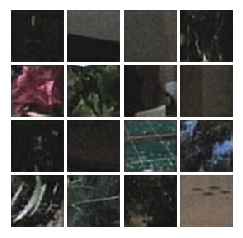

model saved as:  ./saved_models/deno_autoencoder3_epoch_250.pkl
epoch [112/2000], loss:0.0050
epoch [113/2000], loss:0.0068
epoch [114/2000], loss:0.0039
epoch [115/2000], loss:0.0084
epoch [116/2000], loss:0.0045
epoch [117/2000], loss:0.0051
epoch [118/2000], loss:0.0047
epoch [119/2000], loss:0.0053
epoch [120/2000], loss:0.0063
epoch [121/2000], loss:0.0042
===== in function =====
type(images) <class 'numpy.ndarray'>
image.shape before (16, 3, 64, 64)
image.shape after (16, 12288)


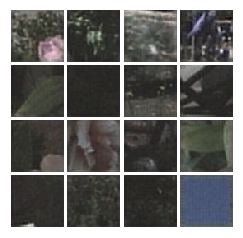

model saved as:  ./saved_models/deno_autoencoder3_epoch_260.pkl
epoch [122/2000], loss:0.0047
epoch [123/2000], loss:0.0052
epoch [124/2000], loss:0.0044
epoch [125/2000], loss:0.0047
epoch [126/2000], loss:0.0042
epoch [127/2000], loss:0.0087
epoch [128/2000], loss:0.0039
epoch [129/2000], loss:0.0036
epoch [130/2000], loss:0.0059
epoch [131/2000], loss:0.0041
===== in function =====
type(images) <class 'numpy.ndarray'>
image.shape before (16, 3, 64, 64)
image.shape after (16, 12288)


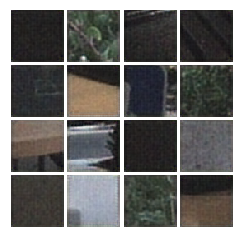

model saved as:  ./saved_models/deno_autoencoder3_epoch_270.pkl
epoch [132/2000], loss:0.0048
epoch [133/2000], loss:0.0041
epoch [134/2000], loss:0.0048
epoch [135/2000], loss:0.0053
epoch [136/2000], loss:0.0073
epoch [137/2000], loss:0.0042
epoch [138/2000], loss:0.0059
epoch [139/2000], loss:0.0048
epoch [140/2000], loss:0.0040
epoch [141/2000], loss:0.0049
===== in function =====
type(images) <class 'numpy.ndarray'>
image.shape before (16, 3, 64, 64)
image.shape after (16, 12288)


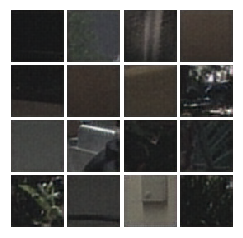

model saved as:  ./saved_models/deno_autoencoder3_epoch_280.pkl
epoch [142/2000], loss:0.0053
epoch [143/2000], loss:0.0037
epoch [144/2000], loss:0.0035
epoch [145/2000], loss:0.0039
epoch [146/2000], loss:0.0042
epoch [147/2000], loss:0.0037
epoch [148/2000], loss:0.0049
epoch [149/2000], loss:0.0050
epoch [150/2000], loss:0.0048
epoch [151/2000], loss:0.0045
===== in function =====
type(images) <class 'numpy.ndarray'>
image.shape before (16, 3, 64, 64)
image.shape after (16, 12288)


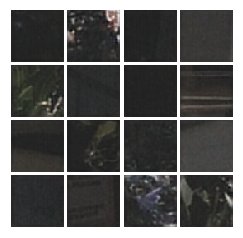

model saved as:  ./saved_models/deno_autoencoder3_epoch_290.pkl
epoch [152/2000], loss:0.0028
epoch [153/2000], loss:0.0084
epoch [154/2000], loss:0.0079
epoch [155/2000], loss:0.0052
epoch [156/2000], loss:0.0039
epoch [157/2000], loss:0.0038
epoch [158/2000], loss:0.0040
epoch [159/2000], loss:0.0042
epoch [160/2000], loss:0.0041
epoch [161/2000], loss:0.0053
===== in function =====
type(images) <class 'numpy.ndarray'>
image.shape before (16, 3, 64, 64)
image.shape after (16, 12288)


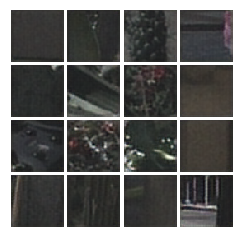

model saved as:  ./saved_models/deno_autoencoder3_epoch_300.pkl
epoch [162/2000], loss:0.0033
epoch [163/2000], loss:0.0046
epoch [164/2000], loss:0.0036
epoch [165/2000], loss:0.0038
epoch [166/2000], loss:0.0047
epoch [167/2000], loss:0.0043
epoch [168/2000], loss:0.0043
epoch [169/2000], loss:0.0055
epoch [170/2000], loss:0.0045
epoch [171/2000], loss:0.0047
===== in function =====
type(images) <class 'numpy.ndarray'>
image.shape before (16, 3, 64, 64)
image.shape after (16, 12288)


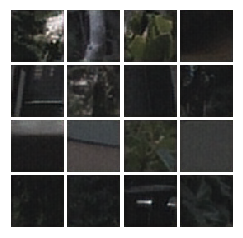

model saved as:  ./saved_models/deno_autoencoder3_epoch_310.pkl
epoch [172/2000], loss:0.0046
epoch [173/2000], loss:0.0039
epoch [174/2000], loss:0.0038
epoch [175/2000], loss:0.0049
epoch [176/2000], loss:0.0046
epoch [177/2000], loss:0.0045
epoch [178/2000], loss:0.0034
epoch [179/2000], loss:0.0056
epoch [180/2000], loss:0.0050
epoch [181/2000], loss:0.0060
===== in function =====
type(images) <class 'numpy.ndarray'>
image.shape before (16, 3, 64, 64)
image.shape after (16, 12288)


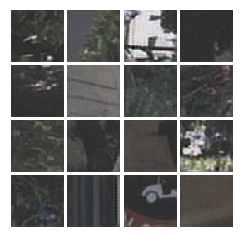

model saved as:  ./saved_models/deno_autoencoder3_epoch_320.pkl
epoch [182/2000], loss:0.0047
epoch [183/2000], loss:0.0043
epoch [184/2000], loss:0.0090
epoch [185/2000], loss:0.0085
epoch [186/2000], loss:0.0059
epoch [187/2000], loss:0.0039
epoch [188/2000], loss:0.0038
epoch [189/2000], loss:0.0057
epoch [190/2000], loss:0.0039
epoch [191/2000], loss:0.0039
===== in function =====
type(images) <class 'numpy.ndarray'>
image.shape before (16, 3, 64, 64)
image.shape after (16, 12288)


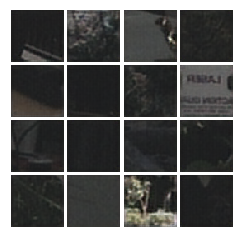

model saved as:  ./saved_models/deno_autoencoder3_epoch_330.pkl
epoch [192/2000], loss:0.0042
epoch [193/2000], loss:0.0050
epoch [194/2000], loss:0.0052
epoch [195/2000], loss:0.0051
epoch [196/2000], loss:0.0031
epoch [197/2000], loss:0.0057
epoch [198/2000], loss:0.0048
epoch [199/2000], loss:0.0048
epoch [200/2000], loss:0.0046
epoch [201/2000], loss:0.0034
===== in function =====
type(images) <class 'numpy.ndarray'>
image.shape before (16, 3, 64, 64)
image.shape after (16, 12288)


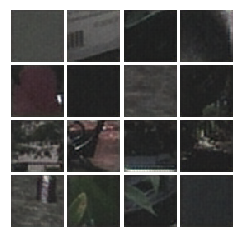

model saved as:  ./saved_models/deno_autoencoder3_epoch_340.pkl
epoch [202/2000], loss:0.0038
epoch [203/2000], loss:0.0049
epoch [204/2000], loss:0.0037
epoch [205/2000], loss:0.0037
epoch [206/2000], loss:0.0043
epoch [207/2000], loss:0.0049
epoch [208/2000], loss:0.0042
epoch [209/2000], loss:0.0037
epoch [210/2000], loss:0.0048
epoch [211/2000], loss:0.0046
===== in function =====
type(images) <class 'numpy.ndarray'>
image.shape before (16, 3, 64, 64)
image.shape after (16, 12288)


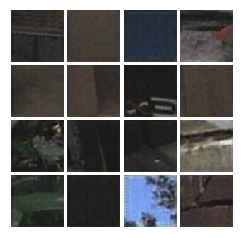

model saved as:  ./saved_models/deno_autoencoder3_epoch_350.pkl
epoch [212/2000], loss:0.0037
epoch [213/2000], loss:0.0047
epoch [214/2000], loss:0.0039
epoch [215/2000], loss:0.0041
epoch [216/2000], loss:0.0045
epoch [217/2000], loss:0.0061
epoch [218/2000], loss:0.0040
epoch [219/2000], loss:0.0033
epoch [220/2000], loss:0.0058
epoch [221/2000], loss:0.0047
===== in function =====
type(images) <class 'numpy.ndarray'>
image.shape before (16, 3, 64, 64)
image.shape after (16, 12288)


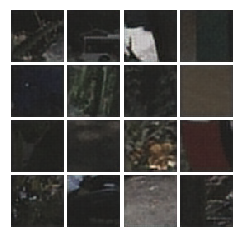

model saved as:  ./saved_models/deno_autoencoder3_epoch_360.pkl
epoch [222/2000], loss:0.0051
epoch [223/2000], loss:0.0043
epoch [224/2000], loss:0.0039
epoch [225/2000], loss:0.0038
epoch [226/2000], loss:0.0031
epoch [227/2000], loss:0.0044
epoch [228/2000], loss:0.0040
epoch [229/2000], loss:0.0042
epoch [230/2000], loss:0.0041
epoch [231/2000], loss:0.0039
===== in function =====
type(images) <class 'numpy.ndarray'>
image.shape before (16, 3, 64, 64)
image.shape after (16, 12288)


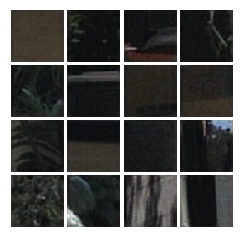

model saved as:  ./saved_models/deno_autoencoder3_epoch_370.pkl
epoch [232/2000], loss:0.0030
epoch [233/2000], loss:0.0041
epoch [234/2000], loss:0.0052
epoch [235/2000], loss:0.0049
epoch [236/2000], loss:0.0039
epoch [237/2000], loss:0.0037
epoch [238/2000], loss:0.0039
epoch [239/2000], loss:0.0029
epoch [240/2000], loss:0.0046
epoch [241/2000], loss:0.0043
===== in function =====
type(images) <class 'numpy.ndarray'>
image.shape before (16, 3, 64, 64)
image.shape after (16, 12288)


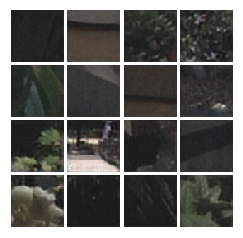

model saved as:  ./saved_models/deno_autoencoder3_epoch_380.pkl
epoch [242/2000], loss:0.0030
epoch [243/2000], loss:0.0090
epoch [244/2000], loss:0.0031
epoch [245/2000], loss:0.0041
epoch [246/2000], loss:0.0032
epoch [247/2000], loss:0.0043
epoch [248/2000], loss:0.0036
epoch [249/2000], loss:0.0035
epoch [250/2000], loss:0.0041
epoch [251/2000], loss:0.0038
===== in function =====
type(images) <class 'numpy.ndarray'>
image.shape before (16, 3, 64, 64)
image.shape after (16, 12288)


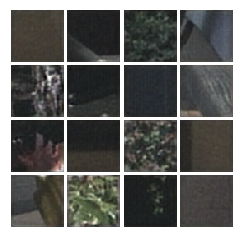

model saved as:  ./saved_models/deno_autoencoder3_epoch_390.pkl
epoch [252/2000], loss:0.0042
epoch [253/2000], loss:0.0040
epoch [254/2000], loss:0.0039
epoch [255/2000], loss:0.0033
epoch [256/2000], loss:0.0037
epoch [257/2000], loss:0.0054
epoch [258/2000], loss:0.0041
epoch [259/2000], loss:0.0044
epoch [260/2000], loss:0.0035
epoch [261/2000], loss:0.0044
===== in function =====
type(images) <class 'numpy.ndarray'>
image.shape before (16, 3, 64, 64)
image.shape after (16, 12288)


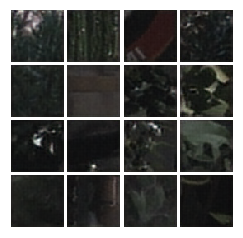

model saved as:  ./saved_models/deno_autoencoder3_epoch_400.pkl
epoch [262/2000], loss:0.0037
epoch [263/2000], loss:0.0063
epoch [264/2000], loss:0.0033
epoch [265/2000], loss:0.0040
epoch [266/2000], loss:0.0042
epoch [267/2000], loss:0.0053
epoch [268/2000], loss:0.0050
epoch [269/2000], loss:0.0063
epoch [270/2000], loss:0.0031
epoch [271/2000], loss:0.0043
===== in function =====
type(images) <class 'numpy.ndarray'>
image.shape before (16, 3, 64, 64)
image.shape after (16, 12288)


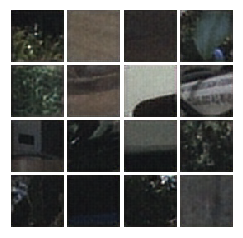

model saved as:  ./saved_models/deno_autoencoder3_epoch_410.pkl
epoch [272/2000], loss:0.0064
epoch [273/2000], loss:0.0054
epoch [274/2000], loss:0.0052
epoch [275/2000], loss:0.0050
epoch [276/2000], loss:0.0031
epoch [277/2000], loss:0.0050
epoch [278/2000], loss:0.0042
epoch [279/2000], loss:0.0043
epoch [280/2000], loss:0.0043
epoch [281/2000], loss:0.0043
===== in function =====
type(images) <class 'numpy.ndarray'>
image.shape before (16, 3, 64, 64)
image.shape after (16, 12288)


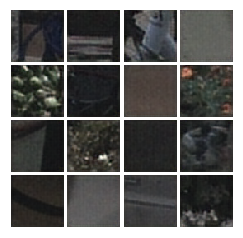

model saved as:  ./saved_models/deno_autoencoder3_epoch_420.pkl
epoch [282/2000], loss:0.0048
epoch [283/2000], loss:0.0057
epoch [284/2000], loss:0.0036
epoch [285/2000], loss:0.0039
epoch [286/2000], loss:0.0045
epoch [287/2000], loss:0.0066
epoch [288/2000], loss:0.0039
epoch [289/2000], loss:0.0049
epoch [290/2000], loss:0.0050
epoch [291/2000], loss:0.0047
===== in function =====
type(images) <class 'numpy.ndarray'>
image.shape before (16, 3, 64, 64)
image.shape after (16, 12288)


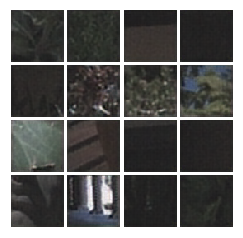

model saved as:  ./saved_models/deno_autoencoder3_epoch_430.pkl
epoch [292/2000], loss:0.0042
epoch [293/2000], loss:0.0037
epoch [294/2000], loss:0.0040
epoch [295/2000], loss:0.0031
epoch [296/2000], loss:0.0055
epoch [297/2000], loss:0.0045
epoch [298/2000], loss:0.0049
epoch [299/2000], loss:0.0057
epoch [300/2000], loss:0.0060
epoch [301/2000], loss:0.0052
===== in function =====
type(images) <class 'numpy.ndarray'>
image.shape before (16, 3, 64, 64)
image.shape after (16, 12288)


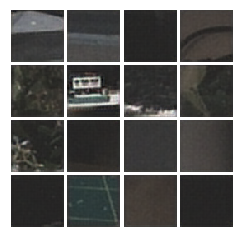

model saved as:  ./saved_models/deno_autoencoder3_epoch_440.pkl
epoch [302/2000], loss:0.0064
epoch [303/2000], loss:0.0061
epoch [304/2000], loss:0.0048
epoch [305/2000], loss:0.0038
epoch [306/2000], loss:0.0037
epoch [307/2000], loss:0.0048
epoch [308/2000], loss:0.0046
epoch [309/2000], loss:0.0056
epoch [310/2000], loss:0.0036
epoch [311/2000], loss:0.0040
===== in function =====
type(images) <class 'numpy.ndarray'>
image.shape before (16, 3, 64, 64)
image.shape after (16, 12288)


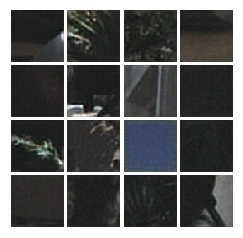

model saved as:  ./saved_models/deno_autoencoder3_epoch_450.pkl
epoch [312/2000], loss:0.0057
epoch [313/2000], loss:0.0027
epoch [314/2000], loss:0.0062
epoch [315/2000], loss:0.0031
epoch [316/2000], loss:0.0034
epoch [317/2000], loss:0.0038
epoch [318/2000], loss:0.0037
epoch [319/2000], loss:0.0049
epoch [320/2000], loss:0.0034
epoch [321/2000], loss:0.0053
===== in function =====
type(images) <class 'numpy.ndarray'>
image.shape before (16, 3, 64, 64)
image.shape after (16, 12288)


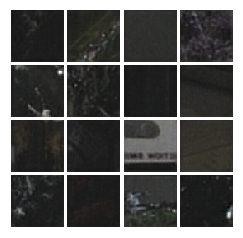

model saved as:  ./saved_models/deno_autoencoder3_epoch_460.pkl
epoch [322/2000], loss:0.0045
epoch [323/2000], loss:0.0042
epoch [324/2000], loss:0.0033
epoch [325/2000], loss:0.0042
epoch [326/2000], loss:0.0042
epoch [327/2000], loss:0.0038
epoch [328/2000], loss:0.0045
epoch [329/2000], loss:0.0045
epoch [330/2000], loss:0.0037
epoch [331/2000], loss:0.0065
===== in function =====
type(images) <class 'numpy.ndarray'>
image.shape before (16, 3, 64, 64)
image.shape after (16, 12288)


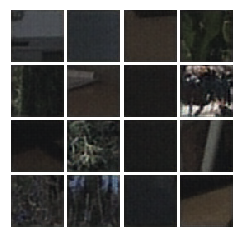

model saved as:  ./saved_models/deno_autoencoder3_epoch_470.pkl
epoch [332/2000], loss:0.0037
epoch [333/2000], loss:0.0040
epoch [334/2000], loss:0.0045
epoch [335/2000], loss:0.0060
epoch [336/2000], loss:0.0047
epoch [337/2000], loss:0.0060
epoch [338/2000], loss:0.0052
epoch [339/2000], loss:0.0044
epoch [340/2000], loss:0.0065
epoch [341/2000], loss:0.0056
===== in function =====
type(images) <class 'numpy.ndarray'>
image.shape before (16, 3, 64, 64)
image.shape after (16, 12288)


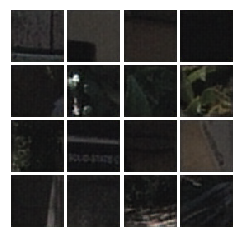

model saved as:  ./saved_models/deno_autoencoder3_epoch_480.pkl
epoch [342/2000], loss:0.0056
epoch [343/2000], loss:0.0053
epoch [344/2000], loss:0.0056
epoch [345/2000], loss:0.0041
epoch [346/2000], loss:0.0046
epoch [347/2000], loss:0.0051
epoch [348/2000], loss:0.0036
epoch [349/2000], loss:0.0045
epoch [350/2000], loss:0.0035
epoch [351/2000], loss:0.0050
===== in function =====
type(images) <class 'numpy.ndarray'>
image.shape before (16, 3, 64, 64)
image.shape after (16, 12288)


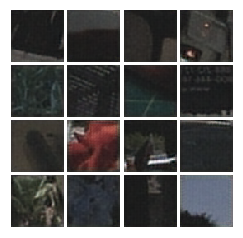

model saved as:  ./saved_models/deno_autoencoder3_epoch_490.pkl
epoch [352/2000], loss:0.0047
epoch [353/2000], loss:0.0039
epoch [354/2000], loss:0.0046
epoch [355/2000], loss:0.0049
epoch [356/2000], loss:0.0040
epoch [357/2000], loss:0.0050
epoch [358/2000], loss:0.0041
epoch [359/2000], loss:0.0064
epoch [360/2000], loss:0.0050
epoch [361/2000], loss:0.0052
===== in function =====
type(images) <class 'numpy.ndarray'>
image.shape before (16, 3, 64, 64)
image.shape after (16, 12288)


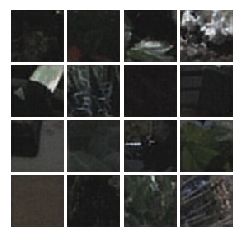

model saved as:  ./saved_models/deno_autoencoder3_epoch_500.pkl
epoch [362/2000], loss:0.0053
epoch [363/2000], loss:0.0052
epoch [364/2000], loss:0.0052
epoch [365/2000], loss:0.0046
epoch [366/2000], loss:0.0050
epoch [367/2000], loss:0.0048


KeyboardInterrupt: 

In [103]:
try:
    autoencoder = torch.load('./saved_models/deno_autoencoder3_epoch_140.pkl')
    print("\n--------model restored--------\n")
except:
    print("\n--------model not restored--------\n")
    pass

# noise = torch.rand(batch_size,channel_size,28,28)
epoch_already = 140
print("Starting run \n")
for epoch in range(num_epochs):
    for image, _ in dataloader:
        noise = torch.randn(image.size()[0], channel_size, crop_img_width, crop_img_width) / 15
        image_n = torch.add(image, noise)
        image_n = torch.clamp(image_n, -1, 1)
        image = Variable(image).type(dtype)
        image_n = Variable(image_n).type(dtype)
        
        optimizer.zero_grad()
        # output of noisy image 
        output = autoencoder(image_n)

        # loss compared to original
        loss = loss_func(output, image)
        
        loss.backward()
        optimizer.step()            
# each run takes 1 min 10 sec

    # ===================log========================
    print('epoch [{}/{}], loss:{:.4f}'
          .format(epoch+1, num_epochs, loss.data[0]))
    if (epoch+epoch_already) % 10 == 0:
        # output.data?
        imgs_numpy = output.data.cpu().numpy() # type(test) <class 'numpy.ndarray'>
        show_images(imgs_numpy[0:16])
        plt.show()
        # pic = to_img(output.cpu().data)
        # save_image(pic, './dc_img/image_{}.png'.format(epoch))
        to_show = inputs[0].view(batch_size, crop_img_width*crop_img_width*channel_size).numpy().squeeze()


    if epoch % 10 ==0:
        saveStr = './saved_models/deno_autoencoder3_epoch_' + str(epoch+epoch_already) + '.pkl'
        torch.save(autoencoder, saveStr)
        print('model saved as: ', saveStr)

(50, 12288)


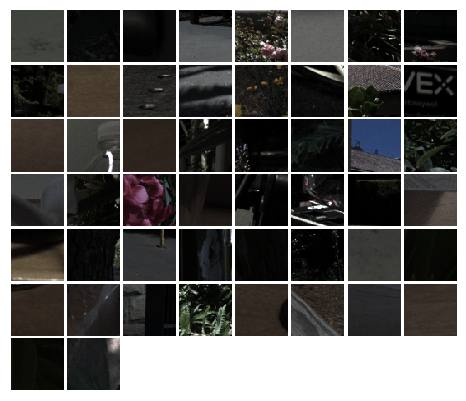

In [12]:
inputs = dataloader.__iter__().next()
to_show = inputs[0].view(batch_size, crop_img_width*crop_img_width*channel_size).numpy().squeeze()
show_images(to_show)


--------model not restored--------

Starting run 

torch.Size([3, 3, 64, 64])
===== in function =====
type(images) <class 'numpy.ndarray'>
image.shape before (3, 12288)
image.shape after (3, 12288)


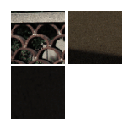

max:  1.0
min:  -1.0
max noise:  0.24295249581336975
min noise:  -0.22837309539318085
max:  1.0
min:  -1.0
===== in function =====
type(images) <class 'numpy.ndarray'>
image.shape before (3, 12288)
image.shape after (3, 12288)


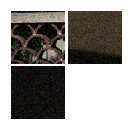

===== in function =====
type(images) <class 'numpy.ndarray'>
image.shape before (3, 3, 64, 64)
image.shape after (3, 12288)


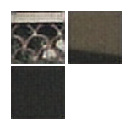

image.size() torch.Size([50, 3, 64, 64])
image_n.size() torch.Size([50, 3, 64, 64])
output.size() torch.Size([50, 3, 64, 64])
origin first (3, 64, 64)
origin second (64, 64, 3)


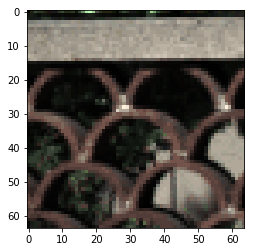

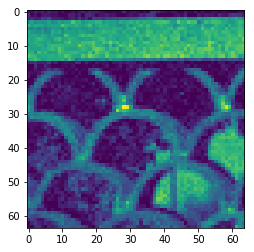

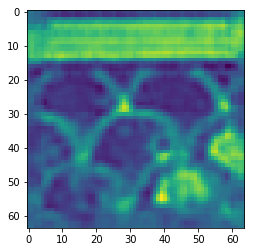

epoch [1/2000], loss:0.0050


In [47]:

try:
    autoencoder = torch.load('./saved_models/deno_autoencoder3_epoch_500.pkl')
    print("\n--------model restored--------\n")
except:
    print("\n--------model not restored--------\n")
    pass

test_epochs = 1

print("Starting run \n")
for epoch in range(test_epochs):
    for image, _ in dataloader:
        print(image[0:3].size())
        show_input = image[0:3].view(3, crop_img_width*crop_img_width*channel_size).numpy().squeeze()
        show_images(show_input)
        plt.show()
        
        print('max: ', torch.max(image))
        print('min: ', torch.min(image))
        
        noise = torch.randn(image.size()[0], channel_size, crop_img_width, crop_img_width) / 20
        
        print('max noise: ', torch.max(noise))
        print('min noise: ', torch.min(noise))
        image_n = torch.add(image, noise)
        image_n = torch.clamp(image_n, -1, 1)

        
        print('max: ', torch.max(image_n))
        print('min: ', torch.min(image_n))
        
        show_noisy = image_n[0:3].view(3, crop_img_width*crop_img_width*channel_size).numpy().squeeze()
        show_images(show_noisy)
        plt.show()
        
        image = Variable(image).type(dtype)
        image_n = Variable(image_n).type(dtype)
        #label = Variable(label.float()).type(dtype)
        optimizer.zero_grad()
        
        # output of noisy image 
        output = autoencoder(image_n)
        
        
        # showing output  image
        show_images(output.data.cpu().numpy()[0:3])
        plt.show()
        
        # showing single image 
        print('image.size()', image.size())
        print('image_n.size()', image_n.size())
        print('output.size()', output.size())
        img = image[0].cpu()
        input_img = image_n[0].cpu()
        output_img = output[0].cpu()

        
        origin = img.data.numpy()
        print('origin first', origin.shape)
        origin = 255.0*(origin-np.min(origin)) / (np.max(origin)-np.min(origin))
        origin = np.swapaxes(np.swapaxes(origin,1,2),0,2)

        # did not work origin = np.rollaxis(origin, 0, 3) 
        print('origin second', origin.shape)

        inp = input_img.data.numpy()
        inp = 255.0*(inp-np.min(inp)) / (np.max(inp)-np.min(inp))
        out = output_img.data.numpy()
        out = 255.0*(out-np.min(out)) / (np.max(out)-np.min(out))
#         print('output', output)
        
        
        test_max = np.max(origin[0])
        test_min = np.min(origin[0])
        origin[0] = 255.0 * (origin[0] - test_min) / (test_max - test_min)

        plt.imshow(origin.astype('uint8'))
        plt.show()

        plt.imshow(inp[0].astype('uint8'))
        plt.show()

        plt.imshow(out[0].astype('uint8'))
        plt.show()
        ###################
        
        # loss compared to original
        loss = loss_func(output, image)
        
        break;
#         loss.backward()
#         optimizer.step()            
        
    # ===================log========================
    print('epoch [{}/{}], loss:{:.4f}'
          .format(epoch+1, num_epochs, loss.data[0]))

    

    


--------model restored--------

Starting run 

torch.Size([3, 3, 64, 64])
===== in function =====
type(images) <class 'numpy.ndarray'>
image.shape before (3, 12288)
image.shape after (3, 12288)


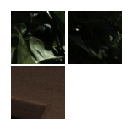

max:  1.0
min:  -1.0
max noise:  0.23354437947273254
min noise:  -0.23302869498729706
max:  1.0
min:  -1.0
===== in function =====
type(images) <class 'numpy.ndarray'>
image.shape before (3, 12288)
image.shape after (3, 12288)


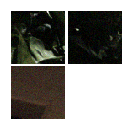

===== in function =====
type(images) <class 'numpy.ndarray'>
image.shape before (3, 3, 64, 64)
image.shape after (3, 12288)


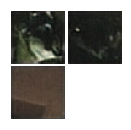

image.size() torch.Size([50, 3, 64, 64])
image_n.size() torch.Size([50, 3, 64, 64])
output.size() torch.Size([50, 3, 64, 64])
origin first (3, 64, 64)
origin second (64, 64, 3)


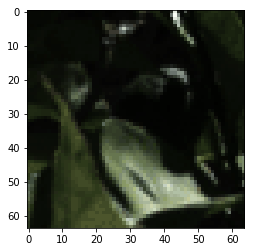

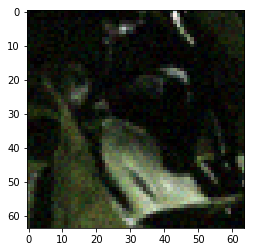

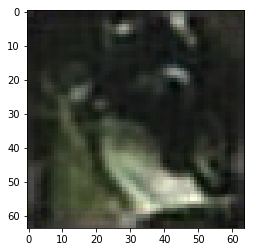

epoch [1/2000], loss:0.0035


In [108]:


try:
    autoencoder = torch.load('./saved_models/deno_autoencoder3_epoch_500.pkl')
    print("\n--------model restored--------\n")
except:
    print("\n--------model not restored--------\n")
    pass

test_epochs = 1

print("Starting run \n")
for epoch in range(test_epochs):
    for image, _ in dataloader:
        print(image[0:3].size())
        show_input = image[0:3].view(3, crop_img_width*crop_img_width*channel_size).numpy().squeeze()
        show_images(show_input)
        plt.show()
        
#         image.data.resize_(real_cpu.size()).copy_(real_cpu)
#         additive_noise.data.resize_(real_cpu.size()).normal_(0, std)
#         input.data.add_(additive_noise.data)
#         output = netD(input)
        
        
        print('max: ', torch.max(image))
        print('min: ', torch.min(image))
        
        noise = torch.randn(image.size()[0], channel_size, crop_img_width, crop_img_width) / 20
        
        print('max noise: ', torch.max(noise))
        print('min noise: ', torch.min(noise))
        image_n = torch.add(image, noise)
        image_n = torch.clamp(image_n, -1, 1)

        
        print('max: ', torch.max(image_n))
        print('min: ', torch.min(image_n))
        
        show_noisy = image_n[0:3].view(3, crop_img_width*crop_img_width*channel_size).numpy().squeeze()
        show_images(show_noisy)
        plt.show()
        
        image = Variable(image).type(dtype)
        image_n = Variable(image_n).type(dtype)
        #label = Variable(label.float()).type(dtype)
        optimizer.zero_grad()
        
        # output of noisy image 
        output = autoencoder(image_n)
        
        
        # showing output  image
        show_images(output.data.cpu().numpy()[0:3])
        plt.show()
        
        # showing single image 
        print('image.size()', image.size())
        print('image_n.size()', image_n.size())
        print('output.size()', output.size())
        img = image[0].cpu()
        input_img = image_n[0].cpu()
        output_img = output[0].cpu()

        
        origin = img.data.numpy()
        print('origin first', origin.shape)
        origin = 255.0*(origin-np.min(origin)) / (np.max(origin)-np.min(origin))
        origin = np.swapaxes(np.swapaxes(origin,1,2),0,2)

        # did not work origin = np.rollaxis(origin, 0, 3) 
        print('origin second', origin.shape)

        inp = input_img.data.numpy()
        inp = 255.0*(inp-np.min(inp)) / (np.max(inp)-np.min(inp))
        inp = np.swapaxes(np.swapaxes(inp,1,2),0,2)
        out = output_img.data.numpy()
        out = 255.0*(out-np.min(out)) / (np.max(out)-np.min(out))
        out = np.swapaxes(np.swapaxes(out,1,2),0,2)
#         print('output', output)
        
        plt.imshow(origin.astype('uint8'))
        plt.show()

        plt.imshow(inp.astype('uint8'))
        plt.show()

        plt.imshow(out.astype('uint8'))
        plt.show()
        ###################
        
        # loss compared to original
        loss = loss_func(output, image)
        
        break;
#         loss.backward()
#         optimizer.step()            
        
    # ===================log========================
    print('epoch [{}/{}], loss:{:.4f}'
          .format(epoch+1, num_epochs, loss.data[0]))

    

    


--------model restored--------

Starting run 

Input Image
origin second (375, 514, 3)


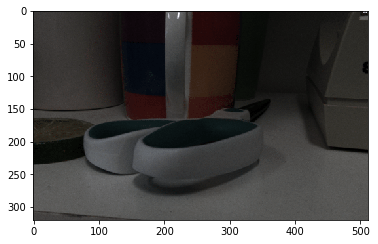

Noisy image (3, 320, 512)
origin second (375, 514, 3)


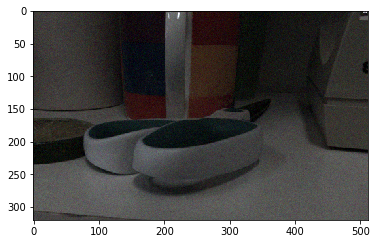

/Users/Max/Documents/lightfield_research/assignment3/.env/lib/python3.5/site-packages/ipykernel_launcher.py:69: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
/Users/Max/Documents/lightfield_research/assignment3/.env/lib/python3.5/site-packages/ipykernel_launcher.py:74: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


Intermediate picture
origin second (375, 514, 3)


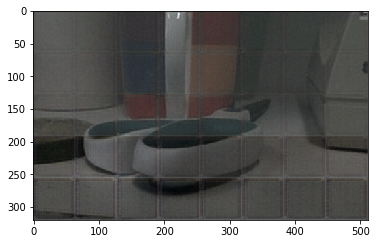

row:  0
row:  1
row:  2
row:  3
row:  4
row:  5
row:  6
row:  7
row:  8
row:  9
row:  10
row:  11
row:  12
row:  13
row:  14
row:  15
row:  16
row:  17
row:  18
row:  19
row:  20
row:  21
row:  22
row:  23
row:  24
row:  25
row:  26
row:  27
row:  28
row:  29
row:  30
row:  31
row:  32
row:  33
row:  34
row:  35
row:  36
row:  37
row:  38
row:  39
row:  40
row:  41
row:  42
row:  43
row:  44
row:  45
row:  46
row:  47
row:  48
row:  49
row:  50
row:  51
row:  52
row:  53
row:  54
row:  55
row:  56
row:  57
row:  58
row:  59
row:  60
row:  61
row:  62
row:  63
row:  64
row:  65
row:  66
row:  67
row:  68
row:  69
row:  70
row:  71
row:  72
row:  73
row:  74
row:  75
row:  76
row:  77
row:  78
row:  79
row:  80
row:  81
row:  82
row:  83
row:  84
row:  85
row:  86
row:  87
row:  88
row:  89
row:  90
row:  91
row:  92
row:  93
row:  94
row:  95
row:  96
row:  97
row:  98
row:  99
row:  100
row:  101
row:  102
row:  103
row:  104
row:  105
row:  106
row:  107
row:  108
row:  109
row:  110


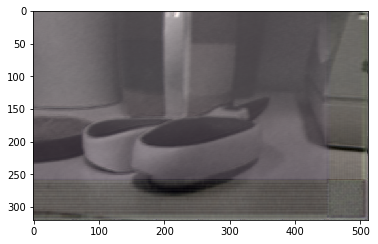

Input Image
origin second (375, 514, 3)


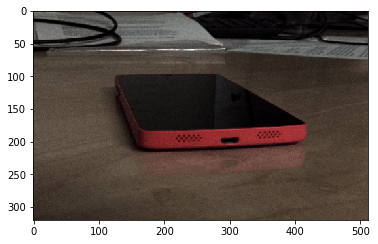

Noisy image (3, 320, 512)
origin second (375, 514, 3)


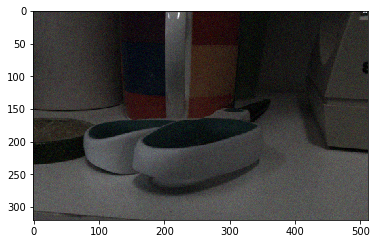

Intermediate picture
origin second (375, 514, 3)


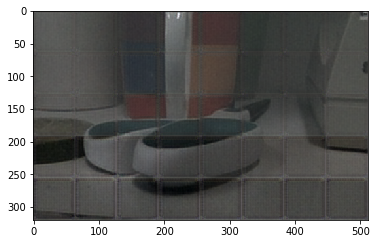

row:  0
row:  1
row:  2
row:  3
row:  4
row:  5
row:  6
row:  7
row:  8
row:  9
row:  10
row:  11
row:  12
row:  13


KeyboardInterrupt: 

In [93]:
# original: 514*375*channel_size
# 375: overlap 4 pixels every time, a normal patch would have effectively 48 pixels
        # with the end images being 56 pixels
        # so if we have 352 pixels, we  take out the edges, we need to cover 240 pixels, which is 5 patches
        # so the patches start at indexes 0, 55, 111, 167, 223, 279, 335, 

# if patches of 64, no overlap, we need 512x320 (8x5)

no_crop_x = 512
no_crop_y = 320
crop_height = 64
crop_width = 64

noise_factor = 20

num_images_to_process = 2

img_transform_no_crop = transforms.Compose([
    transforms.RandomCrop((no_crop_y, no_crop_x)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

dataset_no_crop = datasets.ImageFolder(root='../dataset_center_pixel', transform=img_transform_no_crop)
dataloader_no_crop = DataLoader(dataset_no_crop, batch_size=batch_size, shuffle=True)



try:
    autoencoder = torch.load('./saved_models/deno_autoencoder3_epoch_110.pkl')
    print("\n--------model restored--------\n")
except:
    print("\n--------model not restored--------\n")
    pass

test_epochs = 1

def crop_patch(img, crop_width_x, crop_height_y, startx, starty):
    return img[:, starty : starty+crop_height_y, startx : startx+crop_width_x]

print("Starting run \n")

image_processed_count = 0
for image, _ in dataloader_no_crop:
    while image_processed_count < num_images_to_process:
        # get image 
        # get patch 
        # add noise
        # process
        # attach to result 

        # image 
        print('Input Image')
        show_np_img(image[image_processed_count].cpu().numpy())

        # create noisy numpy image 
        image_n = noisy_tensor(image[image_processed_count], noise_factor)
        image_n = image_n.cpu().numpy()
        
        # show noisy images 
        print('Noisy image', image_n.shape)
        show_np_img(image_n)

        # set up a var for output 
        shell_output = np.empty((image_n.shape[0], no_crop_y, no_crop_x))

        # all the indices for row
        # [   0.   64.  128.  192.  256.  320.  384.  448.  512.]
        index_x = np.linspace(0, no_crop_x, no_crop_x/crop_width+1)
        index_x = index_x[:-1]

        # all the indices for column
        # [   0.   64.  128.  192.  256.  320.]
        index_y = np.linspace(0, no_crop_y, no_crop_y/crop_height+1)
        index_y = index_y[:-1]

        ## first base image 
        # for each column
        for ind_y in index_y:
            ind_y = int(ind_y)

            # obtain a row
            batch_one_row = np.empty((index_x.shape[0], channel_size, crop_img_width, crop_img_width))
            shell_row_idx = 0
            for ind_x in index_x:
                ind_x = int(ind_x)

                # one small patch 
                patch = crop_patch(image_n, crop_img_width, crop_img_width, ind_x, ind_y)
                batch_one_row[shell_row_idx, :, :, :] = patch
                shell_row_idx = shell_row_idx + 1

            # create tensor for this row
            one_row_input = torch.from_numpy(batch_one_row)

            # process one batch row 
            output = autoencoder(Variable(one_row_input).type(dtype))

            # attach row to shell_output
            shell_row_idx = 0
            for ind_x in index_x:
                ind_x = int(ind_x)
                shell_output[:, ind_y:ind_y+crop_img_width, ind_x:ind_x+crop_img_width] = output.data.cpu().numpy()[shell_row_idx]
                shell_row_idx = shell_row_idx + 1
    
    
        # show output
        print('Intermediate picture')
        show_np_img(shell_output)
        
        # running average 
        ## first base image 
        # for each column
        for ind_y in range(no_crop_y-crop_img_width):
            ind_y = int(ind_y)
            print('row: ', ind_y)

            # obtain a row
            batch_one_row = np.empty((no_crop_x-crop_img_width, channel_size, crop_img_width, crop_img_width))
            shell_row_idx = 0
            for ind_x in range(no_crop_x-crop_img_width):
                ind_x = int(ind_x)

                # one small patch 
                patch = crop_patch(image_n, crop_img_width, crop_img_width, ind_x, ind_y)
                batch_one_row[shell_row_idx, :, :, :] = patch
                shell_row_idx = shell_row_idx + 1

            # create tensor for this row
            one_row_input = torch.from_numpy(batch_one_row)

            # process one batch row 
            output = autoencoder(Variable(one_row_input).type(dtype))

            # attach row to shell_output
            shell_row_idx = 0
            for ind_x in range(no_crop_x-crop_img_width):
                ind_x = int(ind_x)
                shell_output[:, ind_y:ind_y+crop_img_width, ind_x:ind_x+crop_img_width] = \
                     np.add(shell_output[:, ind_y:ind_y+crop_img_width, ind_x:ind_x+crop_img_width], 
                                output.data.cpu().numpy()[shell_row_idx]) / 2.0
                shell_row_idx = shell_row_idx + 1

        # show output
        print('Final picture')
        show_np_img(shell_output)
        image_processed_count = image_processed_count + 1
        



--------model restored--------

Starting run 

Input Image
origin second (375, 514, 3)


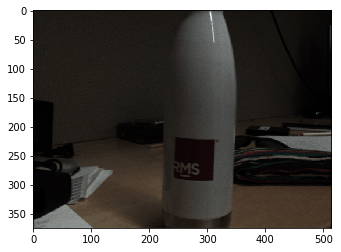

Noisy image (3, 375, 514)
origin second (375, 514, 3)


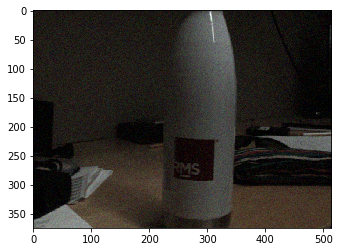

Intermediate picture
origin second (375, 514, 3)


/Users/Max/Documents/lightfield_research/assignment3/.env/lib/python3.5/site-packages/ipykernel_launcher.py:65: RuntimeWarning: invalid value encountered in true_divide


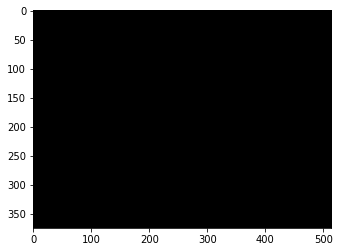

row:  0
row:  1
row:  2
row:  3
row:  4
row:  5
row:  6
row:  7
row:  8
row:  9
row:  10
row:  11
row:  12
row:  13
row:  14
row:  15
row:  16
row:  17
row:  18
row:  19
row:  20
row:  21
row:  22
row:  23
row:  24
row:  25
row:  26
row:  27
row:  28
row:  29
row:  30
row:  31
row:  32
row:  33
row:  34
row:  35
row:  36
row:  37
row:  38
row:  39
row:  40
row:  41
row:  42
row:  43
row:  44
row:  45
row:  46
row:  47
row:  48
row:  49
row:  50
row:  51
row:  52
row:  53
row:  54
row:  55
row:  56
row:  57
row:  58
row:  59
row:  60
row:  61
row:  62
row:  63
row:  64
row:  65
row:  66
row:  67
row:  68
row:  69
row:  70
row:  71
row:  72
row:  73
row:  74
row:  75
row:  76
row:  77
row:  78
row:  79
row:  80
row:  81
row:  82
row:  83
row:  84
row:  85
row:  86
row:  87
row:  88
row:  89
row:  90
row:  91
row:  92
row:  93
row:  94
row:  95
row:  96
row:  97
row:  98
row:  99
row:  100
row:  101
row:  102
row:  103
row:  104
row:  105
row:  106
row:  107
row:  108
row:  109
row:  110


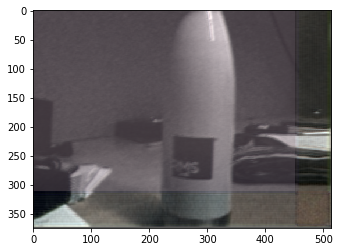

In [99]:
# original: 514*375*channel_size
# 375: overlap 4 pixels every time, a normal patch would have effectively 48 pixels
        # with the end images being 56 pixels
        # so if we have 352 pixels, we  take out the edges, we need to cover 240 pixels, which is 5 patches
        # so the patches start at indexes 0, 55, 111, 167, 223, 279, 335, 

# if patches of 64, no overlap, we need 512x320 (8x5)

no_crop_x = 514
no_crop_y = 375
crop_height = 64
crop_width = 64

noise_factor = 20

num_images_to_process = 1

img_transform_no_crop = transforms.Compose([
    transforms.RandomCrop((no_crop_y, no_crop_x)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

dataset_no_crop = datasets.ImageFolder(root='../dataset_center_pixel', transform=img_transform_no_crop)
dataloader_no_crop = DataLoader(dataset_no_crop, batch_size=batch_size, shuffle=True)



try:
    autoencoder = torch.load('./saved_models/deno_autoencoder3_epoch_110.pkl')
    print("\n--------model restored--------\n")
except:
    print("\n--------model not restored--------\n")
    pass

test_epochs = 1

def crop_patch(img, crop_width_x, crop_height_y, startx, starty):
    return img[:, starty : starty+crop_height_y, startx : startx+crop_width_x]

print("Starting run \n")

image_processed_count = 0
for image, _ in dataloader_no_crop:
    while image_processed_count < num_images_to_process:
        # get image 
        # get patch 
        # add noise
        # process
        # attach to result 

        # image 
        print('Input Image')
        show_np_img(image[image_processed_count].cpu().numpy())
        meanVal = torch.mean(image[image_processed_count])
        

        # create noisy numpy image 
        image_n = noisy_tensor(image[image_processed_count], noise_factor)
        image_n = image_n.cpu().numpy()
        
        # show noisy images 
        print('Noisy image', image_n.shape)
        show_np_img(image_n)

        # set up a var for output 
        shell_output = np.ones((image_n.shape[0], no_crop_y, no_crop_x)) * meanVal

    
        # show output
        print('Intermediate picture')
        show_np_img(shell_output)
        
        # running average 
        ## first base image 
        # for each column
        for ind_y in range(no_crop_y-crop_img_width):
            ind_y = int(ind_y)
            print('row: ', ind_y)

            # obtain a row
            batch_one_row = np.empty((no_crop_x-crop_img_width, channel_size, crop_img_width, crop_img_width))
            shell_row_idx = 0
            for ind_x in range(no_crop_x-crop_img_width):
                ind_x = int(ind_x)

                # one small patch 
                patch = crop_patch(image_n, crop_img_width, crop_img_width, ind_x, ind_y)
                batch_one_row[shell_row_idx, :, :, :] = patch
                shell_row_idx = shell_row_idx + 1

            # create tensor for this row
            one_row_input = torch.from_numpy(batch_one_row)

            # process one batch row 
            output = autoencoder(Variable(one_row_input).type(dtype))

            # attach row to shell_output
            shell_row_idx = 0
            for ind_x in range(no_crop_x-crop_img_width):
                ind_x = int(ind_x)
                shell_output[:, ind_y:ind_y+crop_img_width, ind_x:ind_x+crop_img_width] = \
                     np.add(shell_output[:, ind_y:ind_y+crop_img_width, ind_x:ind_x+crop_img_width], 
                                output.data.cpu().numpy()[shell_row_idx]) / 2.0
                shell_row_idx = shell_row_idx + 1
        
        # show output
        print('Final picture')
        show_np_img(shell_output)
        image_processed_count = image_processed_count + 1
        

In [100]:
print(meanVal)

-0.7743861199604501



--------model restored--------

Starting run 

Input Image
origin second (64, 64, 3)


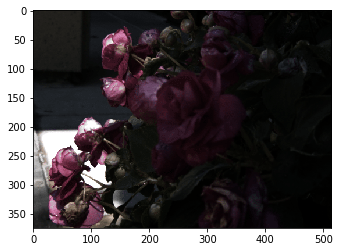

Noisy image (3, 375, 514)
origin second (64, 64, 3)


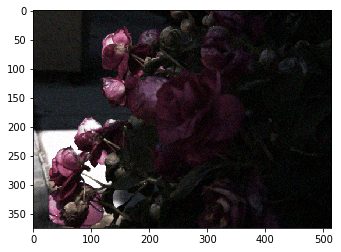

Intermediate picture
origin second (64, 64, 3)


/Users/Max/Documents/lightfield_research/assignment3/.env/lib/python3.5/site-packages/ipykernel_launcher.py:65: RuntimeWarning: invalid value encountered in true_divide


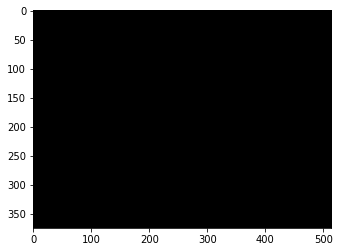

Final picture
origin second (64, 64, 3)


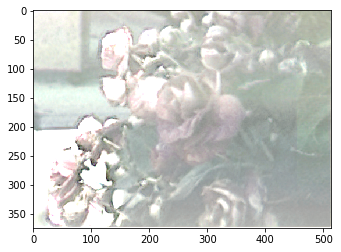

Input Image
origin second (64, 64, 3)


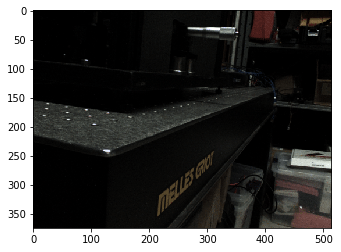

Noisy image (3, 375, 514)
origin second (64, 64, 3)


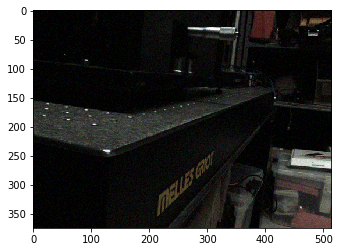

Intermediate picture
origin second (64, 64, 3)


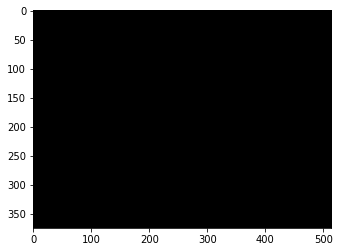

Final picture
origin second (64, 64, 3)


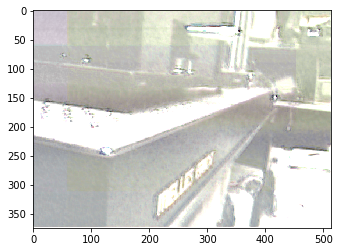

Input Image
origin second (64, 64, 3)


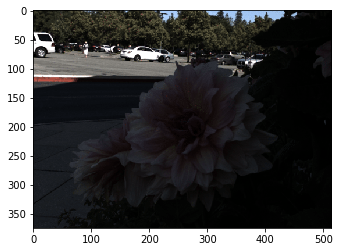

Noisy image (3, 375, 514)
origin second (64, 64, 3)


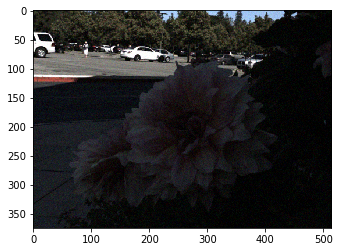

Intermediate picture
origin second (64, 64, 3)


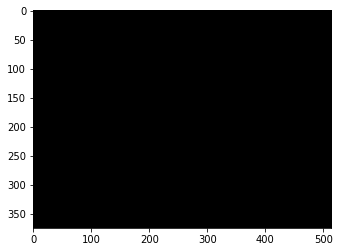

KeyboardInterrupt: 

In [109]:
# original: 514*375*channel_size
# 375: overlap 4 pixels every time, a normal patch would have effectively 48 pixels
        # with the end images being 56 pixels
        # so if we have 352 pixels, we  take out the edges, we need to cover 240 pixels, which is 5 patches
        # so the patches start at indexes 0, 55, 111, 167, 223, 279, 335, 

# if patches of 64, no overlap, we need 512x320 (8x5)

no_crop_x = 514
no_crop_y = 375
crop_height = 64
crop_width = 64

noise_factor = 20

num_images_to_process = 3

img_transform_no_crop = transforms.Compose([
    transforms.RandomCrop((no_crop_y, no_crop_x)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

dataset_no_crop = datasets.ImageFolder(root='../dataset_center_pixel', transform=img_transform_no_crop)
dataloader_no_crop = DataLoader(dataset_no_crop, batch_size=batch_size, shuffle=True)



try:
    autoencoder = torch.load('./saved_models/deno_autoencoder3_epoch_110.pkl')
    print("\n--------model restored--------\n")
except:
    print("\n--------model not restored--------\n")
    pass

test_epochs = 1

def crop_patch(img, crop_width_x, crop_height_y, startx, starty):
    return img[:, starty : starty+crop_height_y, startx : startx+crop_width_x]

print("Starting run \n")

image_processed_count = 0
for image, _ in dataloader_no_crop:
    while image_processed_count < num_images_to_process:
        # get image 
        # get patch 
        # add noise
        # process
        # attach to result 

        # image 
        print('Input Image')
        show_np_img(image[image_processed_count].cpu().numpy())
        meanVal = torch.mean(image[image_processed_count])
        

        # create noisy numpy image 
        image_n = noisy_tensor(image[image_processed_count], noise_factor)
        image_n = image_n.cpu().numpy()
        
        # show noisy images 
        print('Noisy image', image_n.shape)
        show_np_img(image_n)

        # set up a var for output 
        shell_output = np.ones((image_n.shape[0], no_crop_y, no_crop_x)) * meanVal

    
        # show output
        print('Intermediate picture')
        show_np_img(shell_output)
        
        # running average 
        ## first base image 
        # for each column
        for ind_y in range(no_crop_y-crop_img_width):
            ind_y = int(ind_y)

            # obtain a row
            batch_one_row = np.empty((no_crop_x-crop_img_width, channel_size, crop_img_width, crop_img_width))
            shell_row_idx = 0
            for ind_x in range(no_crop_x-crop_img_width):
                ind_x = int(ind_x)

                # one small patch 
                patch = crop_patch(image_n, crop_img_width, crop_img_width, ind_x, ind_y)
                batch_one_row[shell_row_idx, :, :, :] = patch
                shell_row_idx = shell_row_idx + 1

            # create tensor for this row
            one_row_input = torch.from_numpy(batch_one_row)

            # process one batch row 
            output = autoencoder(Variable(one_row_input).type(dtype))

            # attach row to shell_output
            shell_row_idx = 0
            for ind_x in range(no_crop_x-crop_img_width):
                ind_x = int(ind_x)
                shell_output[:, ind_y:ind_y+crop_img_width, ind_x:ind_x+crop_img_width] = \
                     np.minimum(shell_output[:, ind_y:ind_y+crop_img_width, ind_x:ind_x+crop_img_width], 
                                output.data.cpu().numpy()[shell_row_idx])
                shell_row_idx = shell_row_idx + 1
        
        # show output
        print('Final picture')
        show_np_img(shell_output)
        image_processed_count = image_processed_count + 1
        

origin second (64, 64, 3)


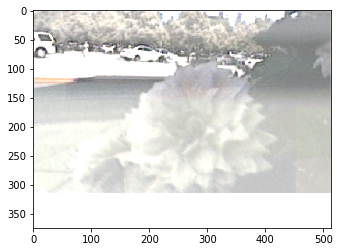

In [111]:
show_np_img(shell_output)